In [28]:
!pip install pandas matplotlib seaborn nltk


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [29]:
import ssl
import nltk

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dagnyparayao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from datetime import datetime
import numpy as np

# Define color palette
colors = ['#9A7092', '#DA85A1', '#5F5566', '#C6DEA6', '#7EBDC3']

# Define terms to analyze
terms = {
    'identity_terms': ['fil am', 'aapi', 'api', 'apa'],
    'slang_terms': ['abg', 'asian baby girl', 'azn', 'fob', 'fresh off the boat', 'yellow fever', 'boba', 'banana', 'white washed']
}

line_styles = ['-', '--', ':', '-.']

In [42]:
def load_and_prepare_data(filepath):
    """Load and prepare the CSV data."""
    df = pd.read_csv(filepath)
    
    # Convert UTC to datetime
    df['created_date'] = pd.to_datetime(df['created_utc'])
    df['year_month'] = df['created_date'].dt.to_period('M')
    
    return df

def analyze_term_frequency(df, terms_dict):
    """Analyze frequency of terms over time."""
    term_counts = pd.DataFrame()
    
    for category, term_list in terms_dict.items():
        for term in term_list:
            mask = df['body'].str.contains(term, case=False, na=False)
            monthly_counts = df[mask].groupby('year_month').size()
            term_counts[term] = monthly_counts

    return term_counts

def analyze_sentiment(df, terms_dict):
    """Analyze sentiment of posts containing terms over time."""
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = pd.DataFrame()
    
    # Group by year_month
    for category, term_list in terms_dict.items():
        for term in term_list:
            # Get posts containing the term
            mask = df['body'].str.contains(term, case=False, na=False)
            term_posts = df[mask].copy()
            
            if not term_posts.empty:
                # Calculate sentiment for each post
                term_posts['sentiment'] = term_posts['body'].apply(
                    lambda x: sia.polarity_scores(x)['compound']
                )
                
                # Calculate average sentiment per month
                monthly_sentiment = term_posts.groupby('year_month')['sentiment'].mean()
                sentiment_scores[term] = monthly_sentiment
    
    return sentiment_scores

def analyze_scores_over_time(df, terms_dict):
    """Analyze average scores of posts containing terms over time."""
    score_trends = pd.DataFrame()
    
    for category, term_list in terms_dict.items():
        for term in term_list:
            mask = df['body'].str.contains(term, case=False, na=False)
            term_posts = df[mask].copy()
            
            if not term_posts.empty:
                # Calculate average score per month
                monthly_scores = term_posts.groupby('year_month')['score'].mean()
                score_trends[term] = monthly_scores
    
    return score_trends

def plot_term_frequency(azn_counts, asian_counts, terms_dict):
    """Plot term frequency over time for both subreddits separately."""
    # Define color palette
    colors = ['#9A7092', '#DA85A1', '#5F5566', '#C6DEA6', '#7EBDC3']
    line_styles = ['-', '--', ':', '-.']

    
    # Create figures for each subreddit
    subreddits = [('r/aznidentity', azn_counts), ('r/asianamerican', asian_counts)]
    
    for subreddit_name, counts in subreddits:
        # Create new figure for each subreddit
        plt.figure(figsize=(20, 15))
        
        # Plot each category as a subplot
        for i, (category, term_list) in enumerate(terms_dict.items()):
            plt.subplot(3, 1, i+1)
            
            # Plot each term
            for term_idx, term in enumerate(term_list):
                if term in counts.columns:
                    color_idx = term_idx % len(colors)  # Cycle through colors if more terms than colors
                    style_idx = (term_idx // len(colors)) % len(line_styles)
                    plt.plot(counts.index.astype(str), 
                           counts[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            
            plt.title(f'{subreddit_name} - {category.replace("_", " ").title()} Frequency Over Time', 
                    fontsize=14, pad=20)
            
            # Rotate x-axis labels
            plt.xticks(rotation=90, ha='center', fontsize=8)
            
            # Add grid
            plt.grid(True, alpha=0.3, linestyle='--')
            
            # Add legend
            plt.legend(fontsize=10, frameon=True, fancybox=True, 
                     shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Add padding
            plt.margins(x=0.02)
        
        # Adjust the layout
        plt.subplots_adjust(bottom=0.2, right=0.85, hspace=0.4)
        
        # Display the plot in Jupyter
        plt.show()
        plt.close()

def plot_sentiment_over_time(azn_sentiment, asian_sentiment, terms_dict):
    """Plot sentiment trends over time for both subreddits separately."""
    # Define color palette and line styles
    colors = ['#9A7092', '#DA85A1', '#5F5566', '#C6DEA6', '#7EBDC3']
    line_styles = ['-', '--', ':', '-.']
    
    # Create figures for each subreddit
    subreddits = [('r/aznidentity', azn_sentiment), ('r/asianamerican', asian_sentiment)]
    
    for subreddit_name, sentiment_data in subreddits:
        # Create new figure for each subreddit
        plt.figure(figsize=(20, 15))
        
        # Plot each category as a subplot
        for i, (category, term_list) in enumerate(terms_dict.items()):
            plt.subplot(3, 1, i+1)
            
            # Plot each term
            for term_idx, term in enumerate(term_list):
                if term in sentiment_data.columns:
                    color_idx = term_idx % len(colors)  # Cycle through colors
                    style_idx = (term_idx // len(colors)) % len(line_styles)  # Change style when color repeats
                    
                    plt.plot(sentiment_data.index.astype(str), 
                           sentiment_data[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            
            plt.title(f'{subreddit_name} - {category.replace("_", " ").title()} Sentiment Over Time', 
                    fontsize=14, pad=20)
            
            # Add y-axis label
            plt.ylabel('Sentiment Score (-1 to 1)', fontsize=10)
            
            # Add horizontal line at y=0 for reference
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            
            # Rotate x-axis labels
            plt.xticks(rotation=90, ha='center', fontsize=8)
            
            # Add grid
            plt.grid(True, alpha=0.3, linestyle='--')
            
            # Add legend
            plt.legend(fontsize=10, frameon=True, fancybox=True, 
                     shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Add padding
            plt.margins(x=0.02)
            
            # Set y-axis limits to show full sentiment range
            plt.ylim(-1, 1)
        
        # Adjust the layout
        plt.subplots_adjust(bottom=0.2, right=0.85, hspace=0.4)
        
        # Display the plot in Jupyter
        plt.show()
        plt.close()

def plot_score_distribution(azn_scores, asian_scores, terms_dict):
    """Plot score trends over time for both subreddits separately."""
    # Define color palette and line styles
    colors = ['#9A7092', '#DA85A1', '#5F5566', '#C6DEA6', '#7EBDC3']
    line_styles = ['-', '--', ':', '-.']
    
    # Create figures for each subreddit
    subreddits = [('r/aznidentity', azn_scores), ('r/asianamerican', asian_scores)]
    
    for subreddit_name, score_data in subreddits:
        # Create new figure for each subreddit
        plt.figure(figsize=(20, 15))
        
        # Plot each category as a subplot
        for i, (category, term_list) in enumerate(terms_dict.items()):
            plt.subplot(3, 1, i+1)
            
            # Plot each term
            for term_idx, term in enumerate(term_list):
                if term in score_data.columns:
                    color_idx = term_idx % len(colors)  # Cycle through colors
                    style_idx = (term_idx // len(colors)) % len(line_styles)  # Change style when color repeats
                    
                    plt.plot(score_data.index.astype(str), 
                           score_data[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            
            plt.title(f'{subreddit_name} - {category.replace("_", " ").title()} Terms Average Scores', 
                    fontsize=14, pad=20)
            
            # Add y-axis label
            plt.ylabel('Average Score', fontsize=10)
            
            # Rotate x-axis labels
            plt.xticks(rotation=90, ha='center', fontsize=8)
            
            # Add grid
            plt.grid(True, alpha=0.3, linestyle='--')
            
            # Add legend
            plt.legend(fontsize=10, frameon=True, fancybox=True, 
                     shadow=True, bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Add padding
            plt.margins(x=0.02)
            
            # Set y-axis to start at 0
            plt.ylim(bottom=0)
        
        # Adjust the layout
        plt.subplots_adjust(bottom=0.2, right=0.85, hspace=0.4)
        
        # Display the plot in Jupyter
        plt.show()
        plt.close()

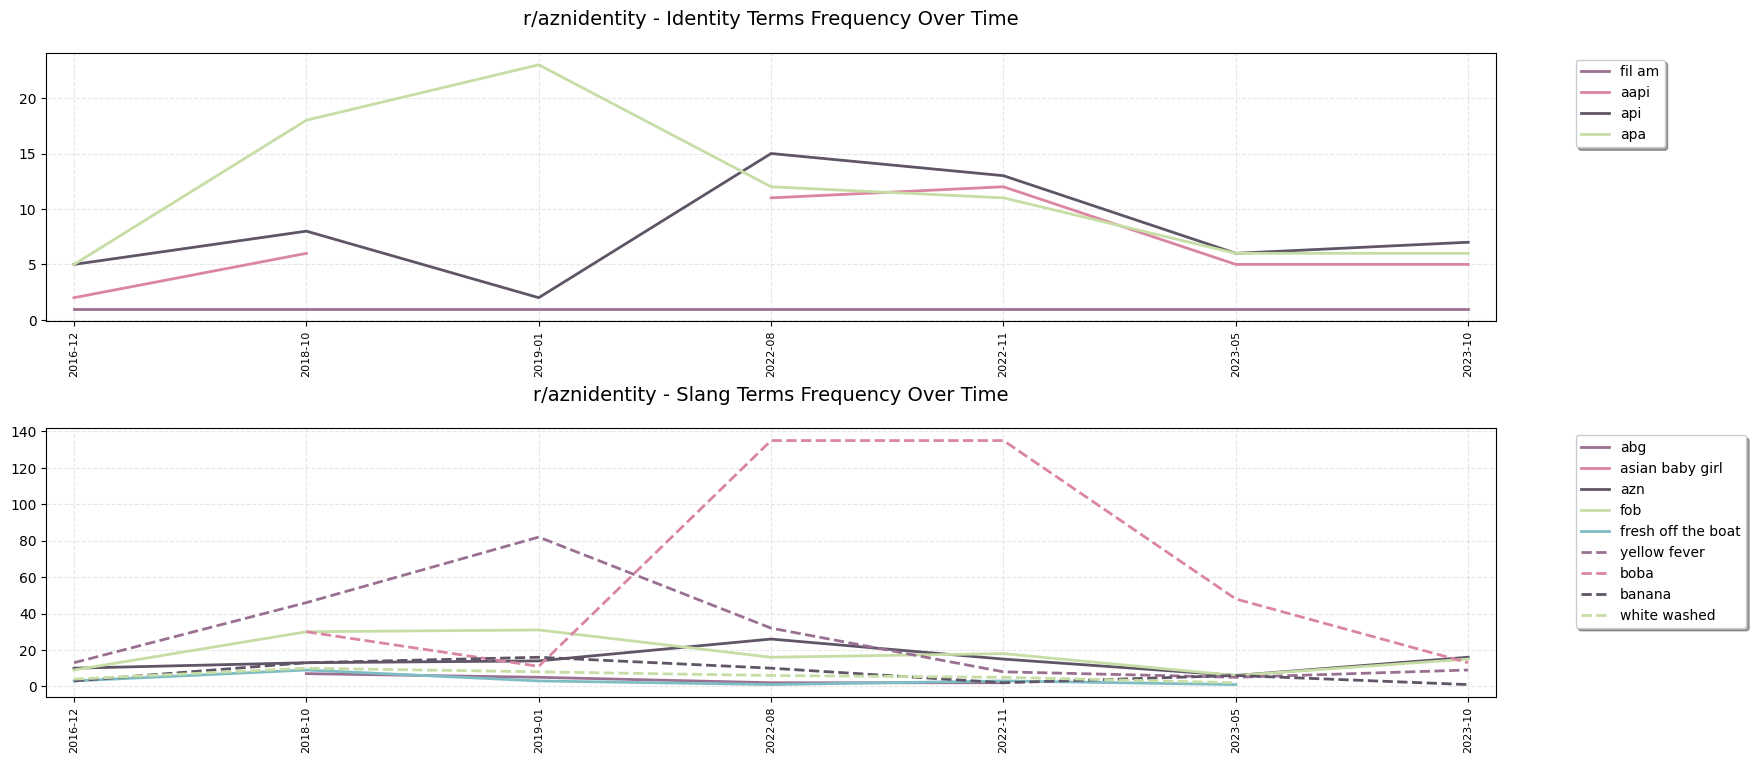

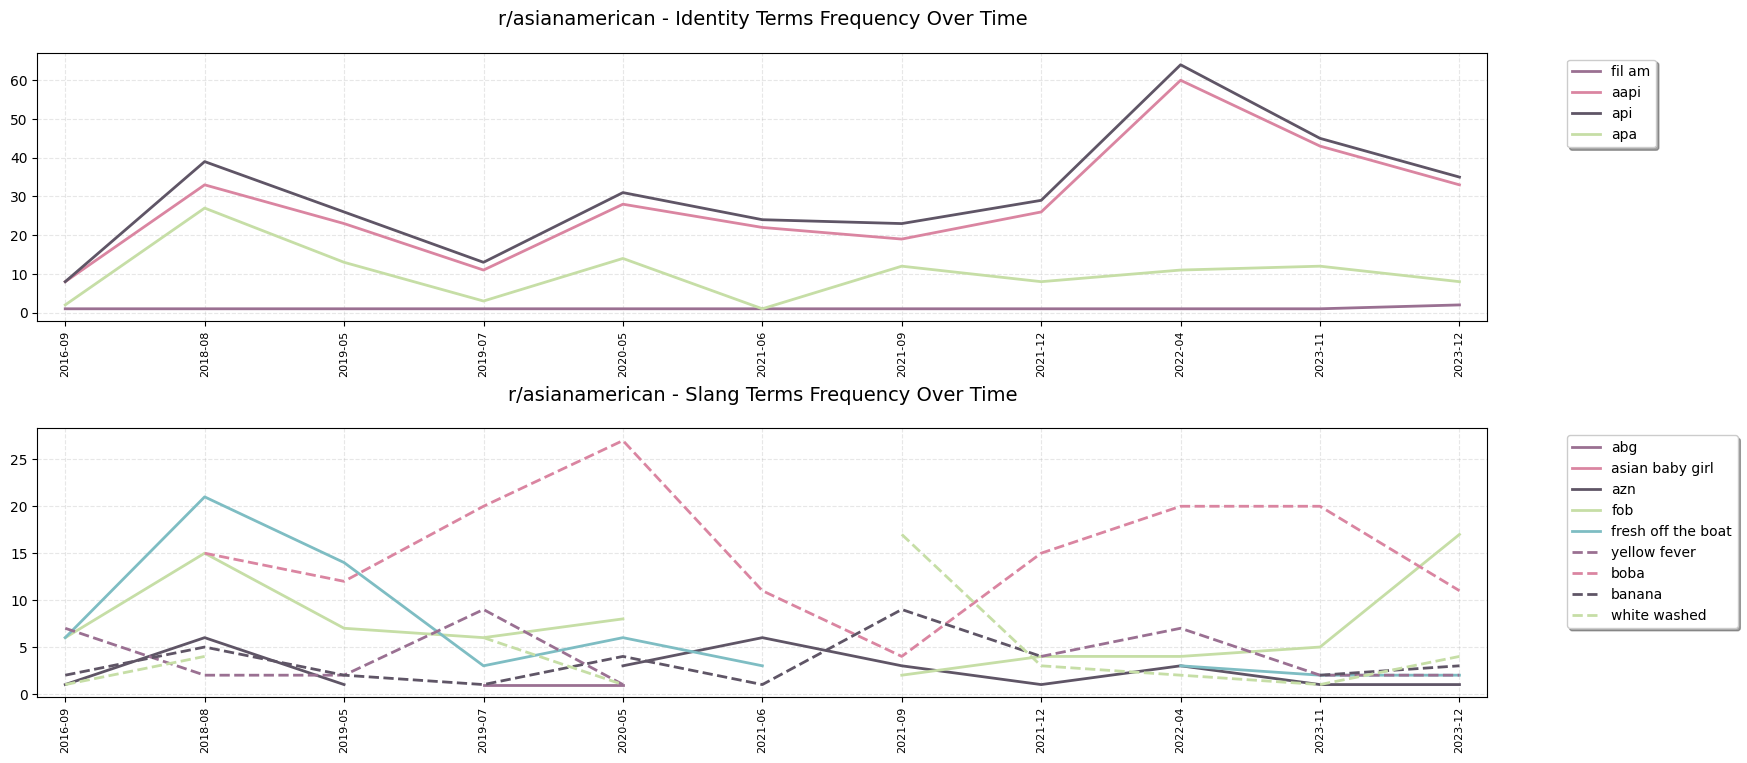

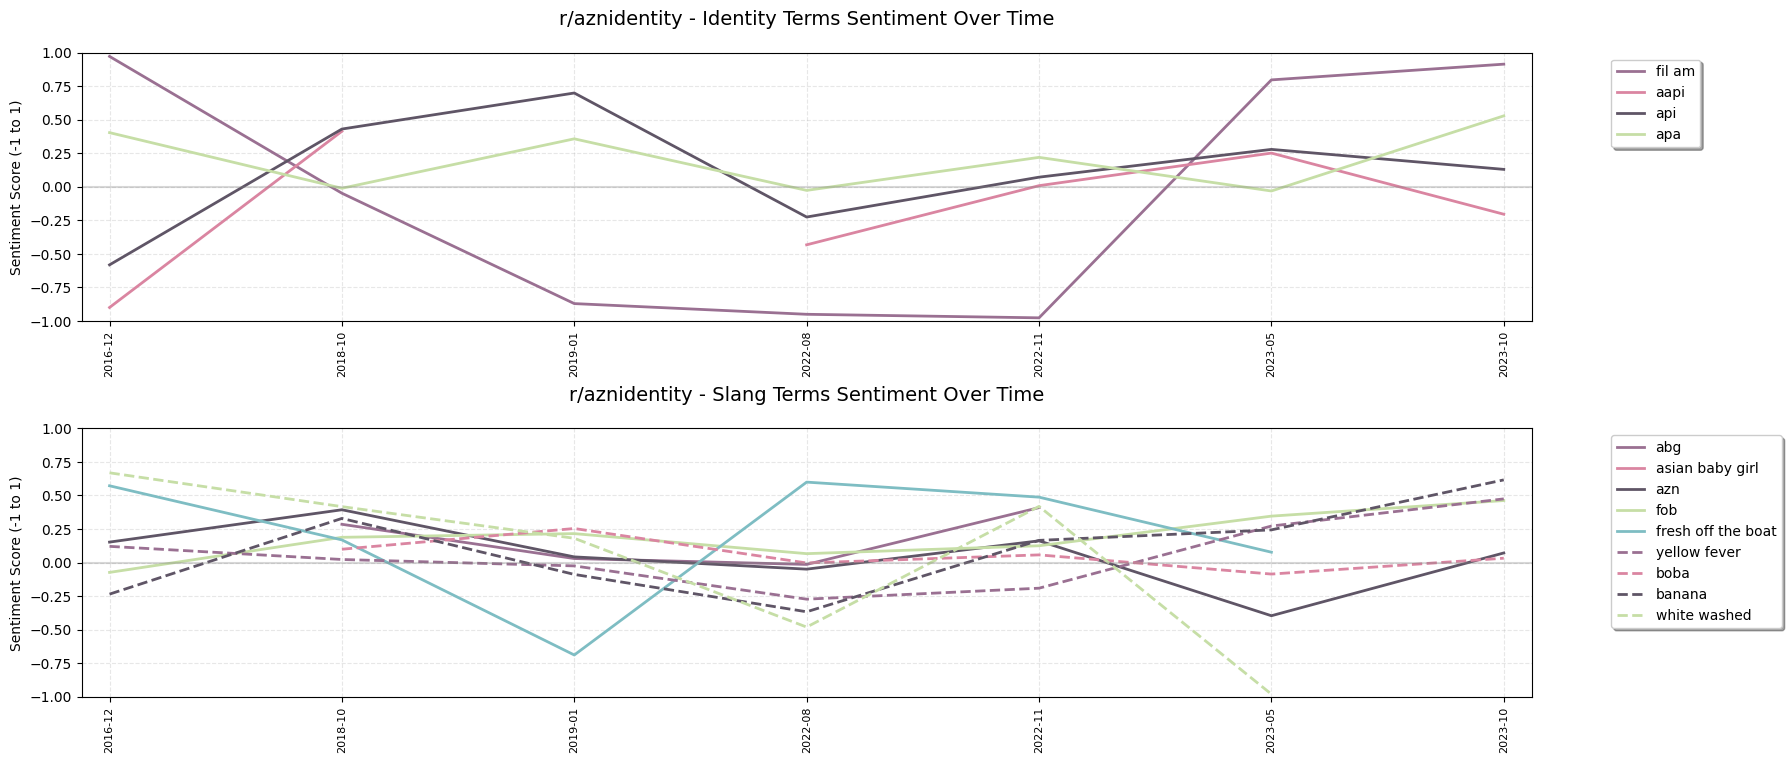

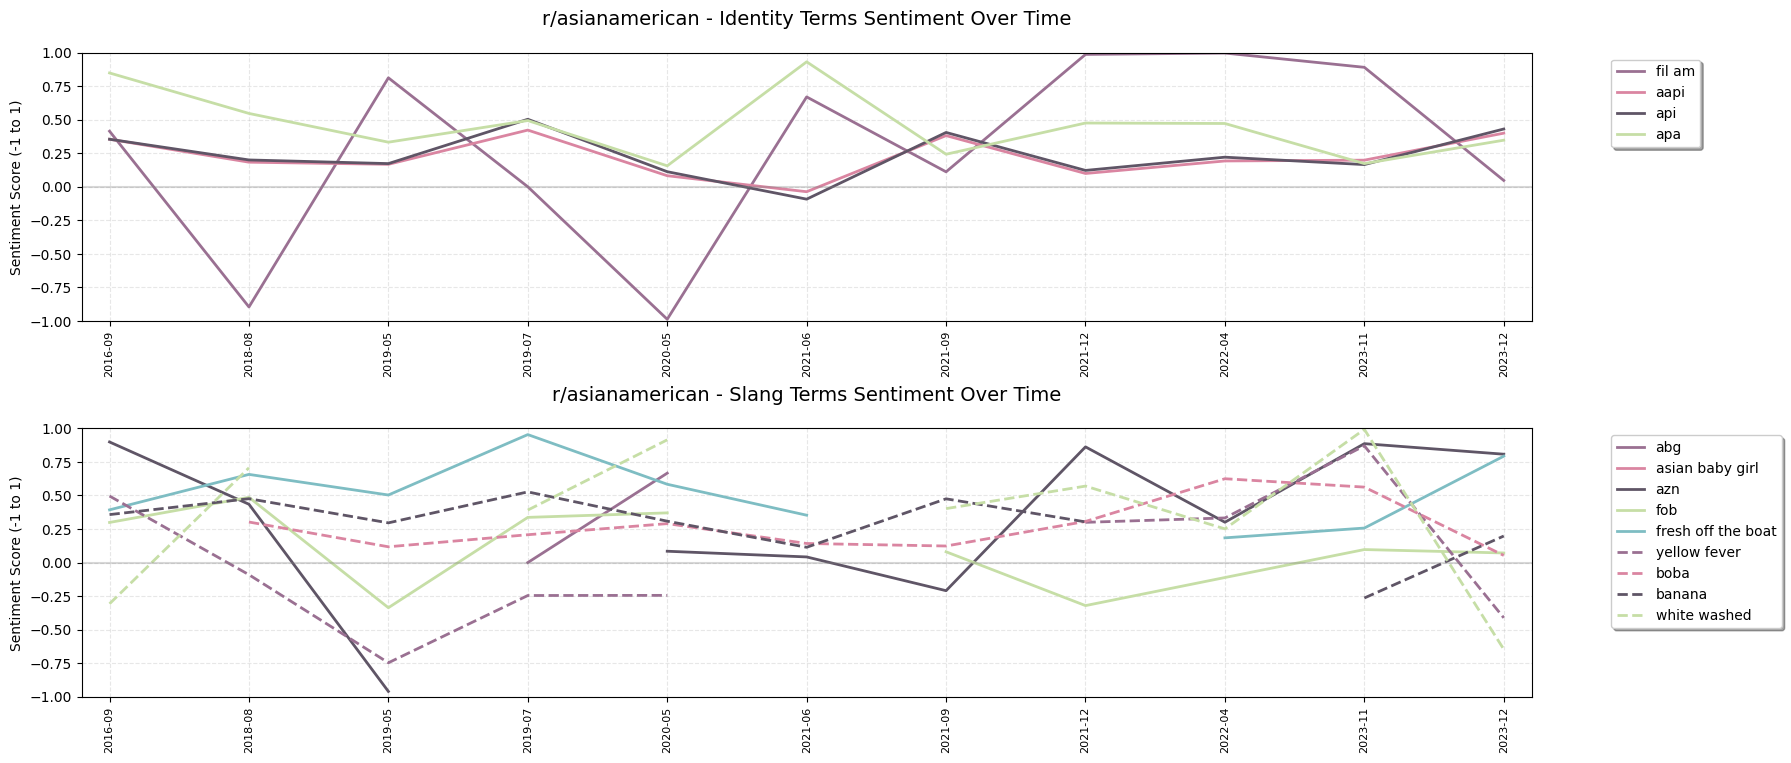

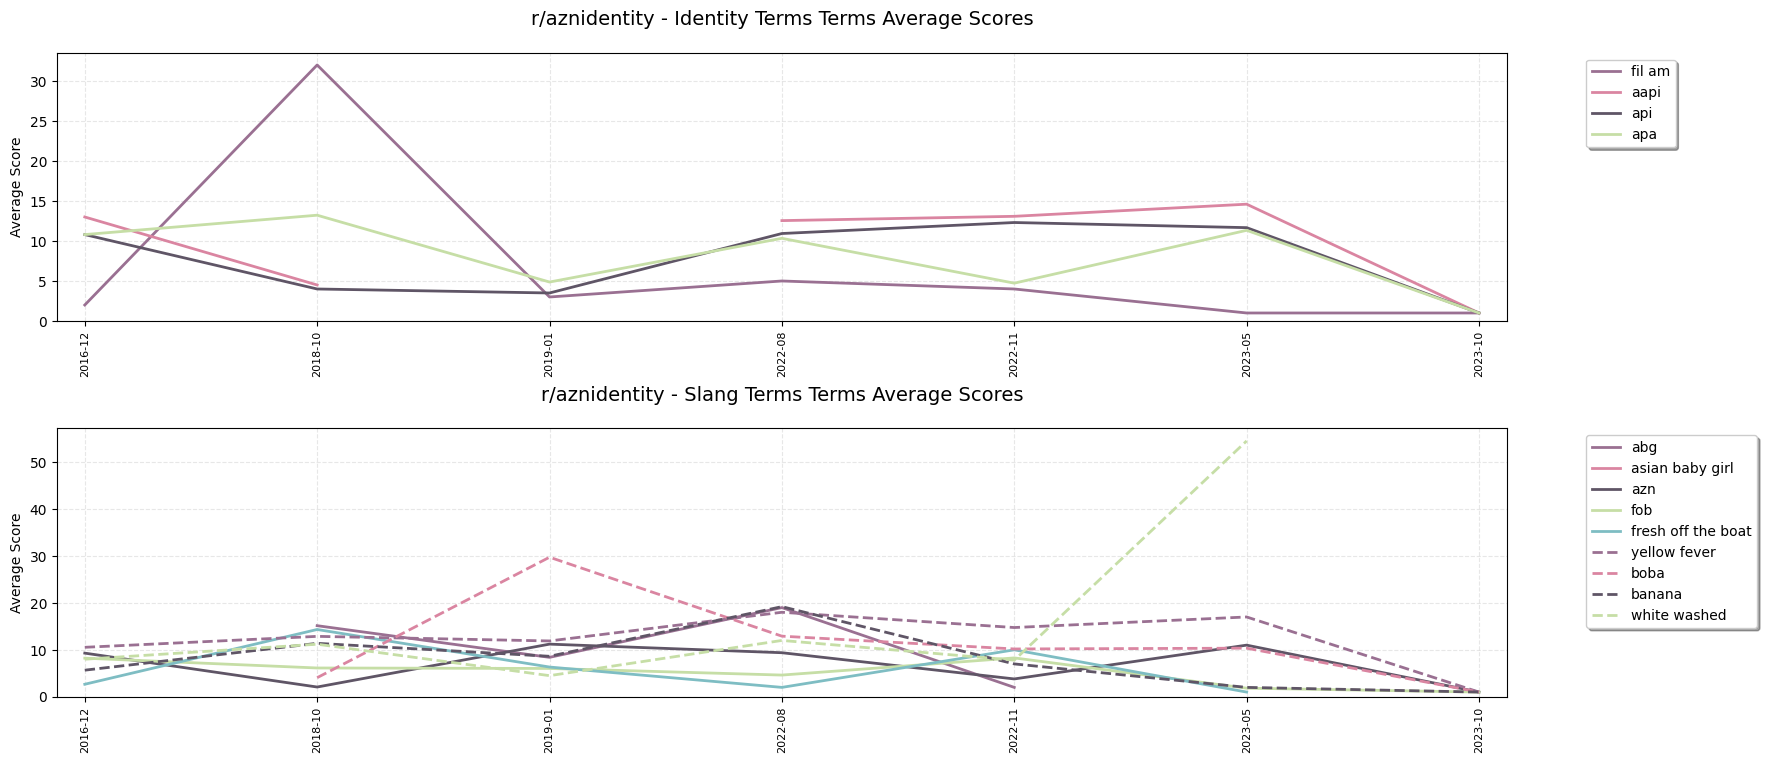

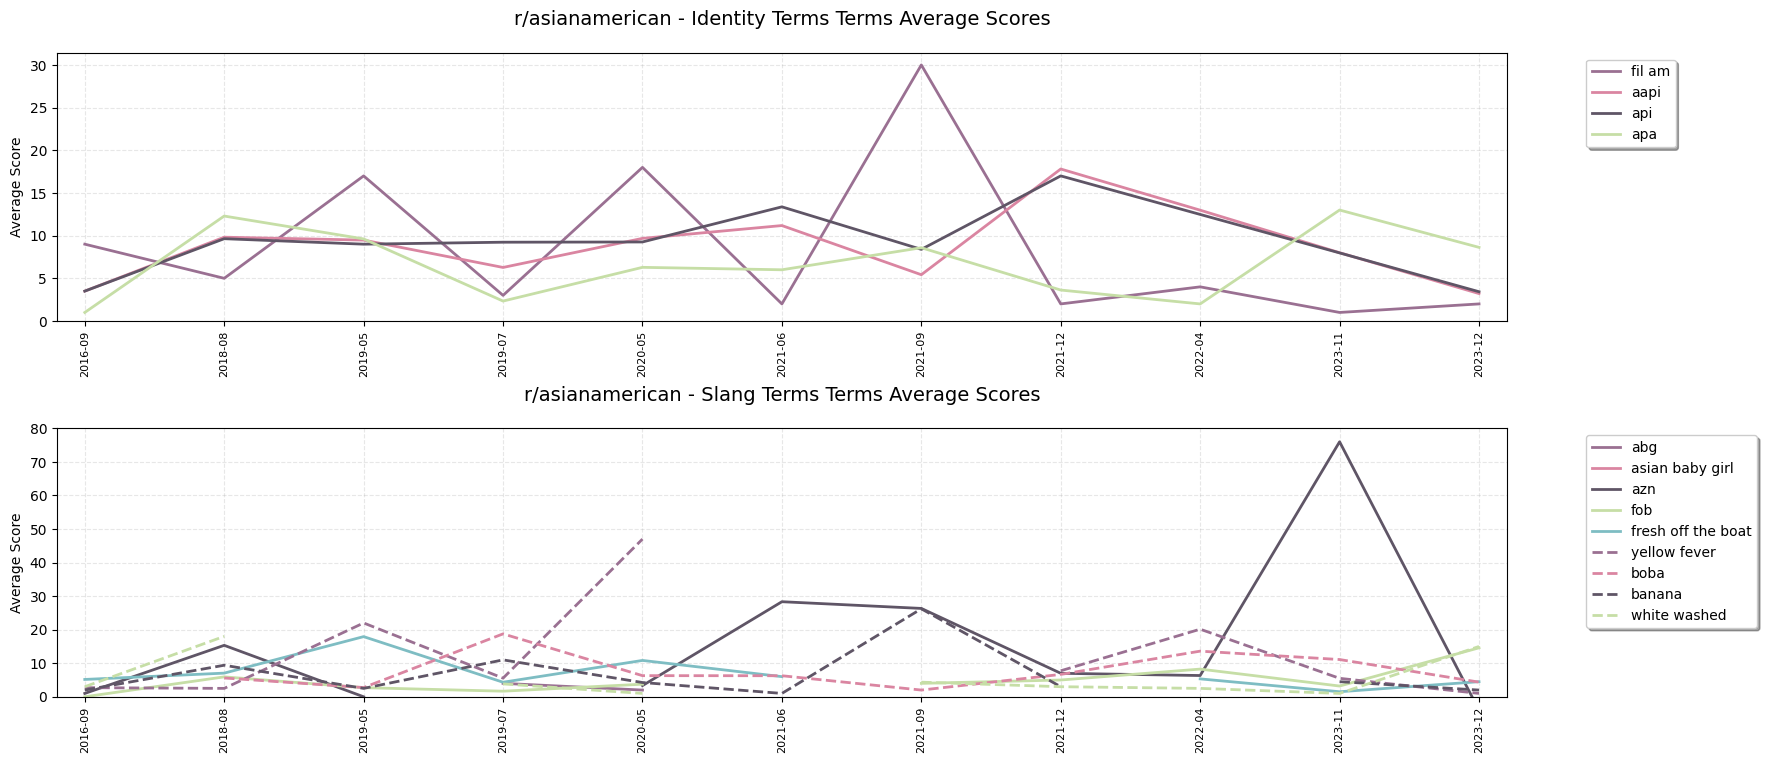


Summary Statistics:

Total number of comments analyzed:
r/aznidentity: 20367
r/asianamerican: 8778

Average sentiment scores:

r/aznidentity:
            fil am   aapi    api    apa    abg  asian baby girl    azn    fob  \
year_month                                                                      
2016-12      0.971 -0.899 -0.582  0.403    NaN              NaN  0.153 -0.073   
2018-10     -0.048  0.414  0.430 -0.011  0.285            0.992  0.393  0.188   
2019-01     -0.870    NaN  0.699  0.357  0.030              NaN  0.042  0.216   
2022-08     -0.950 -0.432 -0.225 -0.027 -0.014            0.976 -0.049  0.066   
2022-11     -0.976  0.008  0.072  0.219  0.409              NaN  0.162  0.125   
2023-05      0.796  0.251  0.279 -0.031    NaN              NaN -0.396  0.346   
2023-10      0.914 -0.205  0.130  0.528 -0.059              NaN  0.072  0.462   

            fresh off the boat  yellow fever   boba  banana  white washed  
year_month                                         

In [ ]:
def main():
    # Load data
    azn_df = load_and_prepare_data('../src/data/aznidentity_comments_terms.csv')
    asian_df = load_and_prepare_data('../src/data/asianamerican_comments_terms.csv')
    
    # Analyze term frequency
    azn_counts = analyze_term_frequency(azn_df, terms)
    asian_counts = analyze_term_frequency(asian_df, terms)
    
    # Analyze sentiment
    azn_sentiment = analyze_sentiment(azn_df, terms)
    asian_sentiment = analyze_sentiment(asian_df, terms)

    # Analyze scores over time
    azn_scores = analyze_scores_over_time(azn_df, terms)
    asian_scores = analyze_scores_over_time(asian_df, terms)
    
    # Create visualizations
    plot_term_frequency(azn_counts, asian_counts, terms)
    plot_sentiment_over_time(azn_sentiment, asian_sentiment, terms)
    plot_score_distribution(azn_scores, asian_scores, terms)
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nTotal number of comments analyzed:")
    print(f"r/aznidentity: {len(azn_df)}")
    print(f"r/asianamerican: {len(asian_df)}")
    
    print("\nAverage sentiment scores:")
    print("\nr/aznidentity:")
    print(azn_sentiment.round(3))
    print("\nr/asianamerican:")
    print(asian_sentiment.round(3))

In [48]:
def save_by_type(azn_counts, asian_counts, azn_sentiment, asian_sentiment, azn_scores, asian_scores, terms_dict):
    """Save graphs grouped by type (frequency, sentiment, scores)"""
    
    # Frequency graphs
    plt.figure(figsize=(25, 15))
    for i, (subreddit_name, counts) in enumerate([('r/aznidentity', azn_counts), ('r/asianamerican', asian_counts)]):
        for j, (category, term_list) in enumerate(terms_dict.items()):
            plt.subplot(2, 3, i*3 + j + 1)
            
            for term_idx, term in enumerate(term_list):
                if term in counts.columns:
                    color_idx = term_idx % len(colors)
                    style_idx = (term_idx // len(colors)) % len(line_styles)
                    plt.plot(counts.index.astype(str), 
                           counts[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            
            plt.title(f'{subreddit_name} - {category.replace("_", " ").title()} Frequency Over Time', 
                    fontsize=12)
            plt.xticks(rotation=90, ha='center', fontsize=8)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.margins(x=0.02)
    
    plt.tight_layout()
    plt.savefig('frequency_comparison.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Sentiment graphs
    plt.figure(figsize=(25, 15))
    for i, (subreddit_name, sentiment_data) in enumerate([('r/aznidentity', azn_sentiment), 
                                                         ('r/asianamerican', asian_sentiment)]):
        for j, (category, term_list) in enumerate(terms_dict.items()):
            plt.subplot(2, 3, i*3 + j + 1)
            
            for term_idx, term in enumerate(term_list):
                if term in sentiment_data.columns:
                    color_idx = term_idx % len(colors)
                    style_idx = (term_idx // len(colors)) % len(line_styles)
                    plt.plot(sentiment_data.index.astype(str), 
                           sentiment_data[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            
            plt.title(f'{subreddit_name} - {category.replace("_", " ").title()} Sentiment Over Time', 
                    fontsize=12)
            plt.ylabel('Sentiment Score (-1 to 1)', fontsize=8)
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            plt.xticks(rotation=90, ha='center', fontsize=8)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.margins(x=0.02)
            plt.ylim(-1, 1)
    
    plt.tight_layout()
    plt.savefig('sentiment_comparison.png', bbox_inches='tight', dpi=300)
    plt.close()
    
    # Score graphs
    plt.figure(figsize=(25, 15))
    for i, (subreddit_name, score_data) in enumerate([('r/aznidentity', azn_scores), 
                                                     ('r/asianamerican', asian_scores)]):
        for j, (category, term_list) in enumerate(terms_dict.items()):
            plt.subplot(2, 3, i*3 + j + 1)
            
            for term_idx, term in enumerate(term_list):
                if term in score_data.columns:
                    color_idx = term_idx % len(colors)
                    style_idx = (term_idx // len(colors)) % len(line_styles)
                    plt.plot(score_data.index.astype(str), 
                           score_data[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            
            plt.title(f'{subreddit_name} - {category.replace("_", " ").title()} Scores Over Time', 
                    fontsize=12)
            plt.ylabel('Average Score', fontsize=8)
            plt.xticks(rotation=90, ha='center', fontsize=8)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.margins(x=0.02)
            plt.ylim(bottom=0)
    
    plt.tight_layout()
    plt.savefig('score_comparison.png', bbox_inches='tight', dpi=300)
    plt.close()

def save_by_subreddit(azn_counts, asian_counts, azn_sentiment, asian_sentiment, azn_scores, asian_scores, terms_dict):
    """Save graphs grouped by subreddit"""
    
    subreddits = [
        ('r/aznidentity', azn_counts, azn_sentiment, azn_scores),
        ('r/asianamerican', asian_counts, asian_sentiment, asian_scores)
    ]
    
    for subreddit_name, counts, sentiment_data, score_data in subreddits:
        plt.figure(figsize=(25, 15))
        
        # Plot all three types for each category
        for i, (category, term_list) in enumerate(terms_dict.items()):
            # Frequency
            plt.subplot(3, 3, i*3 + 1)
            for term_idx, term in enumerate(term_list):
                if term in counts.columns:
                    color_idx = term_idx % len(colors)
                    style_idx = (term_idx // len(colors)) % len(line_styles)
                    plt.plot(counts.index.astype(str), 
                           counts[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            plt.title(f'{category.replace("_", " ").title()} Frequency', fontsize=12)
            plt.xticks(rotation=90, ha='center', fontsize=8)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Sentiment
            plt.subplot(3, 3, i*3 + 2)
            for term_idx, term in enumerate(term_list):
                if term in sentiment_data.columns:
                    color_idx = term_idx % len(colors)
                    style_idx = (term_idx // len(colors)) % len(line_styles)
                    plt.plot(sentiment_data.index.astype(str), 
                           sentiment_data[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            plt.title(f'{category.replace("_", " ").title()} Sentiment', fontsize=12)
            plt.ylabel('Sentiment Score (-1 to 1)', fontsize=8)
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            plt.xticks(rotation=90, ha='center', fontsize=8)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.ylim(-1, 1)
            
            # Scores
            plt.subplot(3, 3, i*3 + 3)
            for term_idx, term in enumerate(term_list):
                if term in score_data.columns:
                    color_idx = term_idx % len(colors)
                    style_idx = (term_idx // len(colors)) % len(line_styles)
                    plt.plot(score_data.index.astype(str), 
                           score_data[term], 
                           label=term,
                           color=colors[color_idx],
                           linestyle=line_styles[style_idx],
                           linewidth=2)
            plt.title(f'{category.replace("_", " ").title()} Scores', fontsize=12)
            plt.ylabel('Average Score', fontsize=8)
            plt.xticks(rotation=90, ha='center', fontsize=8)
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.ylim(bottom=0)
        
        plt.suptitle(subreddit_name, fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig(f'{subreddit_name.replace("/", "_")}_analysis.png', bbox_inches='tight', dpi=300)
        plt.close()

In [51]:
def main():
    # Load data
    azn_df = load_and_prepare_data('../src/data/aznidentity_comments_terms.csv')
    asian_df = load_and_prepare_data('../src/data/asianamerican_comments_terms.csv')
    
    # Analyze term frequency
    azn_counts = analyze_term_frequency(azn_df, terms)
    asian_counts = analyze_term_frequency(asian_df, terms)
    
    # Analyze sentiment
    azn_sentiment = analyze_sentiment(azn_df, terms)
    asian_sentiment = analyze_sentiment(asian_df, terms)
    
    # Analyze scores over time
    azn_scores = analyze_scores_over_time(azn_df, terms)
    asian_scores = analyze_scores_over_time(asian_df, terms)
    
    # Save visualizations grouped by type
    print("Saving graphs grouped by type...")
    save_by_type(azn_counts, asian_counts, azn_sentiment, asian_sentiment, 
                 azn_scores, asian_scores, terms)
    
    # Save visualizations grouped by subreddit
    print("Saving graphs grouped by subreddit...")
    save_by_subreddit(azn_counts, asian_counts, azn_sentiment, asian_sentiment, 
                      azn_scores, asian_scores, terms)
    
    print("\nAll graphs have been saved as PNG files:")
    print("- frequency_comparison.png")
    print("- sentiment_comparison.png")
    print("- score_comparison.png")
    print("- r_aznidentity_analysis.png")
    print("- r_asianamerican_analysis.png")
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nTotal number of comments analyzed:")
    print(f"r/aznidentity: {len(azn_df)}")
    print(f"r/asianamerican: {len(asian_df)}")

if __name__ == "__main__":
    main()

Saving graphs grouped by type...
Saving graphs grouped by subreddit...

All graphs have been saved as PNG files:
- frequency_comparison.png
- sentiment_comparison.png
- score_comparison.png
- r_aznidentity_analysis.png
- r_asianamerican_analysis.png

Summary Statistics:

Total number of comments analyzed:
r/aznidentity: 20367
r/asianamerican: 8778


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from datetime import datetime
import numpy as np
from time import strptime

import ssl
import nltk

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('vader_lexicon')

def parse_twitter_date(date_str):
    """Parse Twitter's date format."""
    return datetime.strptime(date_str, '%a %b %d %H:%M:%S +0000 %Y')

def load_twitter_data(filepath):
    """Load and prepare Twitter CSV data."""
    df = pd.read_csv(filepath)
    df['created_date'] = df['createdAt'].apply(parse_twitter_date)
    df['year_month'] = df['created_date'].dt.to_period('M')
    return df

def load_tiktok_data(filepath):
    """Load and prepare TikTok CSV data."""
    df = pd.read_csv(filepath)
    df['created_date'] = pd.to_datetime(df['createTime'], unit='s')
    df['year_month'] = df['created_date'].dt.to_period('M')
    return df

def load_reddit_data(filepath):
    """Load and prepare Reddit CSV data."""
    df = pd.read_csv(filepath)
    df['created_date'] = pd.to_datetime(df['created_utc'])
    df['year_month'] = df['created_date'].dt.to_period('M')
    return df

def analyze_abg_frequency(df, text_column):
    """Analyze frequency of ABG terms over time."""
    terms = ['abg', 'asian baby girl', 'asian baby gangster']
    mask = df[text_column].str.contains('|'.join(terms), case=False, na=False)
    monthly_counts = df[mask].groupby('year_month').size()
    return monthly_counts

def analyze_abg_sentiment(df, text_column):
    """Analyze sentiment of ABG-related posts over time."""
    sia = SentimentIntensityAnalyzer()
    terms = ['abg', 'asian baby girl', 'asian baby gangster']
    mask = df[text_column].str.contains('|'.join(terms), case=False, na=False)
    term_posts = df[mask].copy()
    
    if not term_posts.empty:
        term_posts['sentiment'] = term_posts[text_column].apply(
            lambda x: sia.polarity_scores(x)['compound']
        )
        monthly_sentiment = term_posts.groupby('year_month')['sentiment'].mean()
        return monthly_sentiment
    return pd.Series()

def plot_platform_analysis(data_dict, platform_name, colors):
    """Create and save frequency and sentiment plots for a platform."""
    # Create figure with two subplots
    plt.figure(figsize=(20, 10))
    
    # Frequency plot
    plt.subplot(1, 2, 1)
    plt.plot(data_dict['frequency'].index.astype(str), 
            data_dict['frequency'],
            color=colors[0],
            linewidth=2,
            label='Frequency')
    plt.title(f'ABG Terms Frequency Over Time - {platform_name}', 
            fontsize=14, pad=20)
    plt.xticks(rotation=90, ha='center', fontsize=8)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=10)
    plt.margins(x=0.02)
    
    # Sentiment plot
    plt.subplot(1, 2, 2)
    plt.plot(data_dict['sentiment'].index.astype(str), 
            data_dict['sentiment'],
            color=colors[1],
            linewidth=2,
            label='Sentiment')
    plt.title(f'ABG Terms Sentiment Over Time - {platform_name}', 
            fontsize=14, pad=20)
    plt.ylabel('Sentiment Score (-1 to 1)', fontsize=10)
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.xticks(rotation=90, ha='center', fontsize=8)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=10)
    plt.margins(x=0.02)
    plt.ylim(-1, 1)
    
    plt.tight_layout()
    plt.savefig(f'abg_analysis_{platform_name.lower().replace("/", "_")}.png', 
               bbox_inches='tight', dpi=300)
    plt.close()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dagnyparayao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
def main():
    # Define color palette
    colors = ['#9A7092', '#DA85A1', '#5F5566', '#C6DEA6', '#7EBDC3']
    
    # Load and analyze Twitter data
    twitter_dfs = []
    for period in ['20062011', '20112017', '20172023']:
        df = load_twitter_data(f'../src/data/twitter_abg_{period}.csv')
        twitter_dfs.append(df)
    twitter_df = pd.concat(twitter_dfs)
    
    twitter_data = {
        'frequency': analyze_abg_frequency(twitter_df, 'text'),
        'sentiment': analyze_abg_sentiment(twitter_df, 'text')
    }
    
    # Load and analyze TikTok data
    tiktok_df = load_tiktok_data('../src/data/tiktok.csv')
    tiktok_data = {
        'frequency': analyze_abg_frequency(tiktok_df, 'text'),
        'sentiment': analyze_abg_sentiment(tiktok_df, 'text')
    }
    
    # Load and analyze Reddit data for both subreddits
    azn_df = load_reddit_data('../src/data/aznidentity_comments_abg.csv')
    asian_df = load_reddit_data('../src/data/asianamerican_comments_abg.csv')
    
    aznidentity_data = {
        'frequency': analyze_abg_frequency(azn_df, 'body'),
        'sentiment': analyze_abg_sentiment(azn_df, 'body')
    }
    
    asianamerican_data = {
        'frequency': analyze_abg_frequency(asian_df, 'body'),
        'sentiment': analyze_abg_sentiment(asian_df, 'body')
    }
    
    # Create and save plots for each platform
    plot_platform_analysis(twitter_data, 'Twitter', colors[:2])
    plot_platform_analysis(tiktok_data, 'TikTok', colors[1:3])
    plot_platform_analysis(aznidentity_data, 'r/aznidentity', colors[2:4])
    plot_platform_analysis(asianamerican_data, 'r/asianamerican', colors[3:5])
    
    print("Analysis complete! Generated files:")
    print("- abg_analysis_twitter.png")
    print("- abg_analysis_tiktok.png")
    print("- abg_analysis_r_aznidentity.png")
    print("- abg_analysis_r_asianamerican.png")

if __name__ == "__main__":
    main()

Analysis complete! Generated files:
- abg_analysis_twitter.png
- abg_analysis_tiktok.png
- abg_analysis_r_aznidentity.png
- abg_analysis_r_asianamerican.png
